In [34]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from scipy import stats 
import statsmodels.api as sm
import statsmodels.stats.api as sms

Consider following data generating scheme:
<p>
Parameters
<li> $N$ = sample size
<li> $p$ = probability of treatment
<li> $b$ = ATE (treatment effect)
</p>

<p>$Y_{pre}$ ~ Normal(1,1)</p>
<p>$A$ ~ Bernoulli(p)</p>
<p>$Y_{post}$ ~ Normal($b$*$A$ + $y_{pre}^2$, 1)

Run a simulation based on the following generated data as above and estimate the treatment effects using:
<li> Differences in means</li>
<li> Regression controlling for y_pre</li>
<li> CUPED controlling for y_pre</li>
<li> Difference in differences</li>

Repeat 10K times and assess bias and variance

## Coding CUPED

In [35]:
def cuped_adjustment(X, Y, assignment):
    cv = np.cov(X, Y)
    theta = cv[0,1] / cv[1,1]
    X_mu = np.mean(X)
    Y_cuped = Y - (X - X_mu)*theta
    return Y_cuped

# example implementation
# https://bytepawn.com/reducing-variance-in-ab-testing-with-cuped.html

In [36]:
def p_value(A,B):
    return stats.ttest_ind(A, B)

In [118]:
data = [x for x in range(100, 10000, 100)]
p = 0.1
b = 5

df = []
for i in data:
    Y_pre = np.random.normal(1, 1, i)
    A = np.random.binomial(1, p, i)
    Y_post = A*b  + np.square(Y_pre) + np.random.normal(0,1)

    simulation = pd.DataFrame({'Y_pre':Y_pre, 'Treatment':A, 'Y_post':Y_post})

    treatment = simulation[simulation['Treatment'] == 1]
    control = simulation[simulation['Treatment'] == 0]

    t_mu = treatment['Y_post'].mean()
    c_mu = control['Y_post'].mean()
#     print("for N = {}".format(i))



#     print("difference in means:")
    mu_diff = t_mu - c_mu
    mean_diff_cm = sms.CompareMeans(sms.DescrStatsW(treatment['Y_post'].values), 
                                    sms.DescrStatsW(control['Y_post'].values))
    mean_diff_conf = mean_diff_cm.tconfint_diff(usevar='unequal')
    diff_means = {'method': 'diff_in_means',
                       'N': i,
                       'observed_treatment_effect':mu_diff,
                       'conf_int':mean_diff_conf}       
    
#     print(mu_diff)
#     print(mean_diff_conf)
#     print()
    
    
    alpha = 0.05
    X = simulation.iloc[:, :2].values
    Y = simulation['Y_post'].values

    model_lr = sm.OLS(Y, sm.add_constant(X)).fit()
    conf_interval = model_lr.conf_int(alpha)
    b_conf_int = conf_interval[-1]
    

    #check that coef of our treatment effect, should return  b
#     b_hat = model.coef_[1]
#     print("regression controlled treatment effect")
#     print(model_lr.summary())
#     print(model_lr.params[-1])
#     print(b_conf_int)
    regression_data = {'method': 'regression',
                       'N': i,
                       'observed_treatment_effect':model_lr.params[-1],
                       'conf_int':tuple(b_conf_int)}    
    
#     print()

#     print("CUPED Adjusted Mean")
    Y_cuped = cuped_adjustment(X[:, 0],Y,A)
#     X is covariates, Y is outcome, A = assignment
    Y_t_cuped = Y_cuped[np.where(A==1)]
    Y_c_cuped = Y_cuped[np.where(A==0)]
    
    t_cuped_mu = np.mean(Y_t_cuped)
    c_cuped_mu = np.mean(Y_c_cuped)
    diff_cuped = t_cuped_mu - c_cuped_mu
    cm = sms.CompareMeans(sms.DescrStatsW(Y_t_cuped), sms.DescrStatsW(Y_c_cuped))
    cuped_conf = cm.tconfint_diff(usevar='unequal')
#     print(cm.tconfint_diff(usevar='unequal'))
#     pval = p_value(Y_t_cuped, Y_c_cuped)
#     print(diff_cuped)
#     print(pval)
#     print(cm)
#     print()
#     build dataframe
    cuped_data = {'method': 'cuped',
                  'N': i,
                  'observed_treatment_effect':diff_cuped,
                  'conf_int':cuped_conf}
    
    df.append(diff_means)
    df.append(regression_data)
    df.append(cuped_data)
                                                   
                                                   
    

In [119]:
mydata = pd.DataFrame.from_dict(df)

mydata['conf_low'] = mydata['conf_int'].apply(lambda x: x[0])
mydata['conf_high'] = mydata['conf_int'].apply(lambda x: x[1])
mydata['conf_width'] = mydata['conf_high'] - mydata['conf_low'] 

In [121]:
import matplotlib.pyplot as plt

In [122]:
mydata['method'].unique()

array(['diff_in_means', 'regression', 'cuped'], dtype=object)

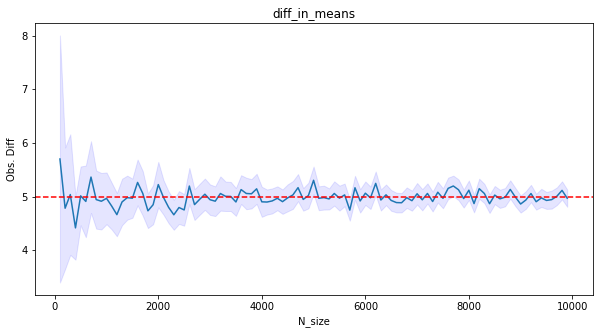

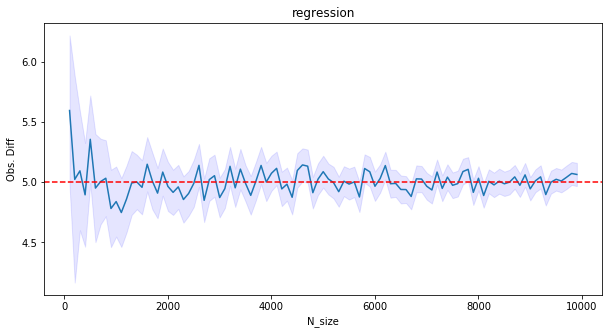

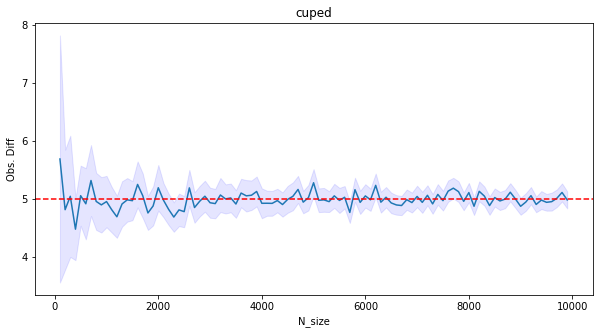

In [124]:
for m in mydata['method'].unique():

    fig, ax = plt.subplots(figsize=(10,5))

    x = mydata[mydata['method'] == m]['N'].values
    y = mydata[mydata['method'] == m]['observed_treatment_effect'].values
    ci_low = mydata[mydata['method'] == m]['conf_low'].values
    ci_high = mydata[mydata['method'] == m]['conf_high'].values
    
    ax.plot(x,y)
    plt.axhline(y=5, color='r', linestyle='--')
    ax.fill_between(x, (ci_low), (ci_high), color='b', alpha=.1)
    ax.set_title(m)
    ax.set_xlabel('N_size')
    ax.set_ylabel('Obs. Diff')


# mydata[mydata['method'] == 'diff_in_means'].plot(x = 'N', y = 'observed_treatment_effect')

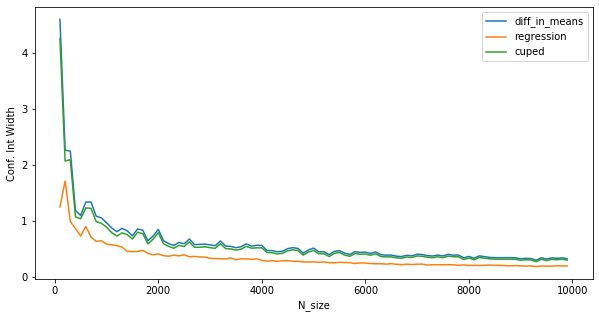

In [125]:
fig, ax = plt.subplots(figsize=(10,5))

for m in mydata['method'].unique():

    x = mydata[mydata['method'] == m]['N'].values
    y = mydata[mydata['method'] == m]['conf_width'].values
    
    ax.plot(x,y, label = m)
# ax.set_title(m)s
ax.set_xlabel('N_size')
ax.set_ylabel('Conf. Int Width')
ax.legend()


# mydata[mydata['method'] == 'diff_in_means'].plot(x = 'N', y = 'observed_treatment_effect')

## Changing parameters p and b

In [133]:
data = [x for x in range(100, 10000, 100)]
p_array = [x*0.1 for x in range(0, 10, 1)]
b_array = [x*.5 for x in range(0, 10, 1)]

df = []
for i in data:
    for p in p_array:
        for b in b_array:
            Y_pre = np.random.normal(1, 1, i)
            A = np.random.binomial(1, p, i)
            Y_post = A*b  + np.square(Y_pre) + np.random.normal(0,1)

            simulation = pd.DataFrame({'Y_pre':Y_pre, 'Treatment':A, 'Y_post':Y_post})

            treatment = simulation[simulation['Treatment'] == 1]
            control = simulation[simulation['Treatment'] == 0]

            t_mu = treatment['Y_post'].mean()
            c_mu = control['Y_post'].mean()
        #     print("for N = {}".format(i))



        #     print("difference in means:")
            mu_diff = t_mu - c_mu
            mean_diff_cm = sms.CompareMeans(sms.DescrStatsW(treatment['Y_post'].values), 
                                            sms.DescrStatsW(control['Y_post'].values))
            mean_diff_conf = mean_diff_cm.tconfint_diff(usevar='unequal')
            diff_means = {'method': 'diff_in_means',
                               'N': i,
                               'observed_treatment_effect':mu_diff,
                               'conf_int':mean_diff_conf,
                                 'treatment_prob': p,
                                 'treatment_effect': b}       

        #     print(mu_diff)
        #     print(mean_diff_conf)
        #     print()


            alpha = 0.05
            X = simulation.iloc[:, :2].values
            Y = simulation['Y_post'].values

            model_lr = sm.OLS(Y, sm.add_constant(X)).fit()
            conf_interval = model_lr.conf_int(alpha)
            b_conf_int = conf_interval[-1]


            #check that coef of our treatment effect, should return  b
        #     b_hat = model.coef_[1]
        #     print("regression controlled treatment effect")
        #     print(model_lr.summary())
        #     print(model_lr.params[-1])
        #     print(b_conf_int)
            regression_data = {'method': 'regression',
                               'N': i,
                               'observed_treatment_effect':model_lr.params[-1],
                               'conf_int':tuple(b_conf_int),
                               'treatment_prob': p,
                                 'treatment_effect': b}       

        #     print()

        #     print("CUPED Adjusted Mean")
            Y_cuped = cuped_adjustment(X[:, 0],Y,A)
        #     X is covariates, Y is outcome, A = assignment
            Y_t_cuped = Y_cuped[np.where(A==1)]
            Y_c_cuped = Y_cuped[np.where(A==0)]

            t_cuped_mu = np.mean(Y_t_cuped)
            c_cuped_mu = np.mean(Y_c_cuped)
            diff_cuped = t_cuped_mu - c_cuped_mu
            cm = sms.CompareMeans(sms.DescrStatsW(Y_t_cuped), sms.DescrStatsW(Y_c_cuped))
            cuped_conf = cm.tconfint_diff(usevar='unequal')
        #     print(cm.tconfint_diff(usevar='unequal'))
        #     pval = p_value(Y_t_cuped, Y_c_cuped)
        #     print(diff_cuped)
        #     print(pval)
        #     print(cm)
        #     print()
        #     build dataframe
            cuped_data = {'method': 'cuped',
                          'N': i,
                          'observed_treatment_effect':diff_cuped,
                          'conf_int':cuped_conf,
                                 'treatment_prob': p,
                                 'treatment_effect': b}       

            df.append(diff_means)
            df.append(regression_data)
            df.append(cuped_data)




C:\Users\shuan\anaconda3\lib\site-packages\statsmodels\stats\weightstats.py:133: RuntimeWarning: invalid value encountered in double_scalars
  return self.sum / self.sum_weights
C:\Users\shuan\anaconda3\lib\site-packages\statsmodels\stats\weightstats.py:188: RuntimeWarning: invalid value encountered in double_scalars
  return self.sumsquares / self.sum_weights
C:\Users\shuan\anaconda3\lib\site-packages\scipy\stats\_continuous_distns.py:5739: RuntimeWarning: invalid value encountered in greater
  return df > 0
C:\Users\shuan\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\shuan\anaconda3\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [134]:
mydata = pd.DataFrame.from_dict(df)

mydata['conf_low'] = mydata['conf_int'].apply(lambda x: x[0])
mydata['conf_high'] = mydata['conf_int'].apply(lambda x: x[1])
mydata['conf_width'] = mydata['conf_high'] - mydata['conf_low'] 

In [138]:
mydata['treatment_prob'].unique()

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

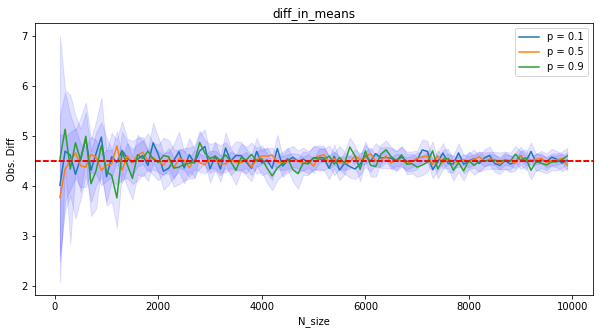

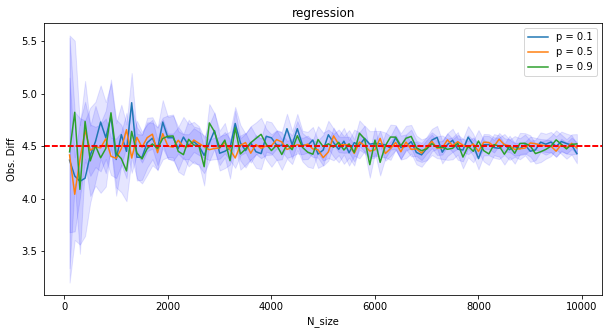

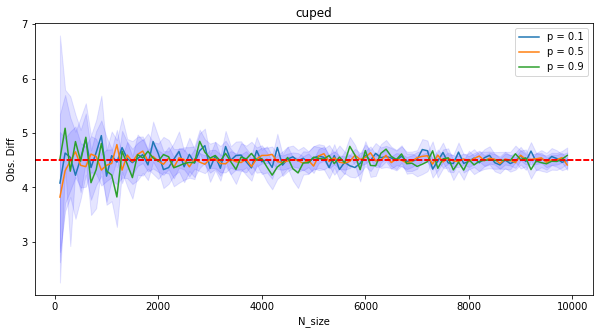

In [162]:
for m in mydata['method'].unique():
    data = mydata[(mydata['method'] == m) & (mydata['treatment_effect'] == 4.5)]
    fig, ax = plt.subplots(figsize=(10,5))

    for p in [0.1,0.5, 0.9]:


        x = data[(data['treatment_prob'] == p)]['N'].values
        y = data[(data['treatment_prob'] == p)]['observed_treatment_effect'].values
        ci_low = data[(data['treatment_prob'] == p)]['conf_low'].values
        ci_high = data[(data['treatment_prob'] == p)]['conf_high'].values

        ax.plot(x,y, label = 'p = {}'.format(p))
        plt.axhline(y=4.5, color='r', linestyle='--')
        ax.fill_between(x, (ci_low), (ci_high), color='b', alpha=.1)
    ax.set_title(m)
    ax.legend()
    ax.set_xlabel('N_size')
    ax.set_ylabel('Obs. Diff')


# mydata[mydata['method'] == 'diff_in_means'].plot(x = 'N', y = 'observed_treatment_effect')

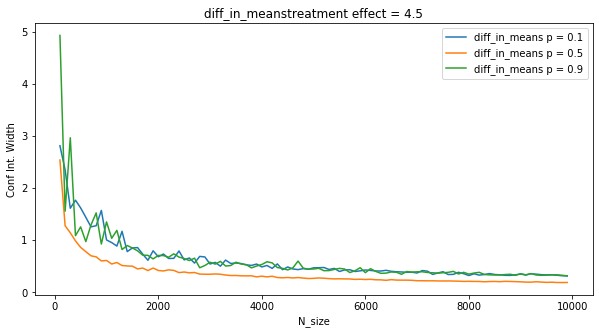

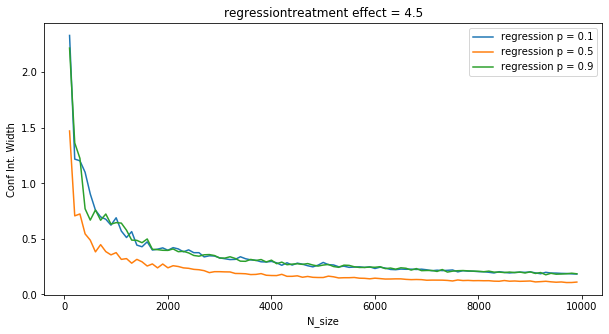

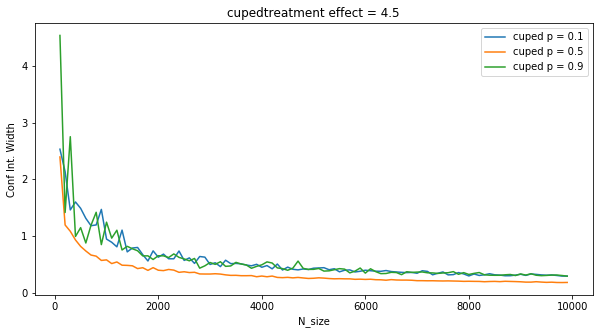

In [163]:

for m in mydata['method'].unique():
    data = mydata[(mydata['method'] == m) & (mydata['treatment_effect'] == 4.5)]
#     fig, ax = plt.subplots(figsize=(10,5))
    fig, ax = plt.subplots(figsize=(10,5))

    for p in [0.1,0.5, 0.9]:


        x = data[(data['treatment_prob'] == p)]['N'].values
        y = data[(data['treatment_prob'] == p)]['conf_width'].values

        ax.plot(x,y, label = '{} p = {}'.format(m, p))
    ax.set_title(m + ' treatment effect = {}'.format(4.5))
    ax.legend()
    ax.set_xlabel('N_size')
    ax.set_ylabel('Conf Int. Width')


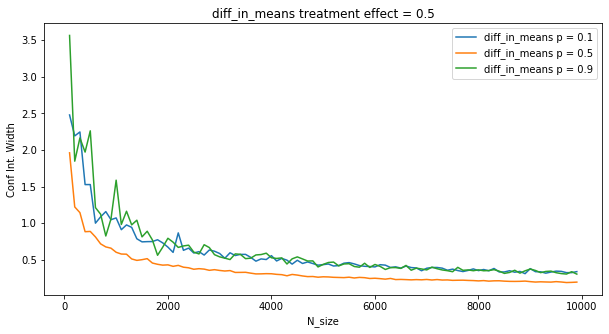

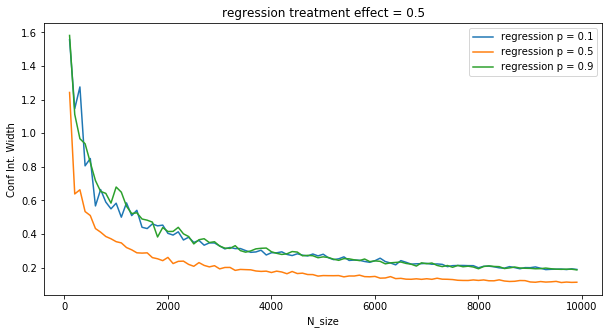

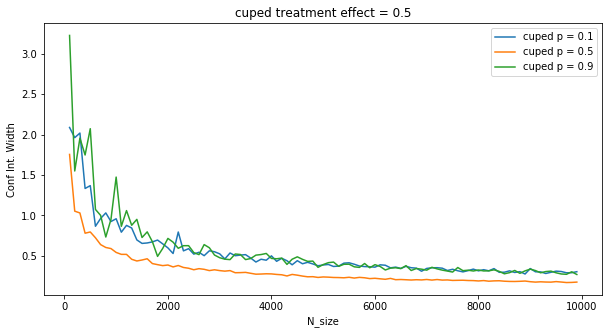

In [165]:

for m in mydata['method'].unique():
    data = mydata[(mydata['method'] == m) & (mydata['treatment_effect'] == 0.5)]
#     fig, ax = plt.subplots(figsize=(10,5))
    fig, ax = plt.subplots(figsize=(10,5))

    for p in [0.1,0.5, 0.9]:


        x = data[(data['treatment_prob'] == p)]['N'].values
        y = data[(data['treatment_prob'] == p)]['conf_width'].values

        ax.plot(x,y, label = '{} p = {}'.format(m, p))
    ax.set_title(m + ' treatment effect = {}'.format(0.5))
    ax.legend()
    ax.set_xlabel('N_size')
    ax.set_ylabel('Conf Int. Width')
